In [138]:
import pandas as pd
import numpy as np
from scipy.stats import f, norm, chi2

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import math
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from IPython.display import display


Loại bỏ giá trị ngoại lai

In [139]:
def remove_outliers_iqr(df, col):
    """
    Loại bỏ ngoại lai theo phương pháp IQR cho một biến col
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean = df[(df[col] >= lower) & (df[col] <= upper)].copy()

    print("----- LOẠI BỎ NGOẠI LAI -----")
    print(f"Biến: {VAR_LABELS.get(col, col)}")
    print(f"Ngưỡng dưới: {lower:.4f}")
    print(f"Ngưỡng trên: {upper:.4f}")
    print(f"Số quan sát ban đầu: {len(df)}")
    print(f"Số quan sát sau làm sạch: {len(df_clean)}")
    print(f"Số quan sát bị loại: {len(df) - len(df_clean)}\n")

    return df_clean

Đọc bộ dữ liệu

In [140]:
# Đọc dữ liệu
#df = pd.read_csv('Bộ dữ liệu con.csv', encoding='utf-8-sig') # Có biến giả
df = pd.read_csv('RiceFarms_cleaned.csv', encoding='utf-8-sig') # Không có biến giả

# Loại bỏ ngoại lai cho biến sản lượng
# df = remove_outliers_iqr(df, "goutput")

In [141]:
# ===================== BƯỚC 1. XÁC ĐỊNH MÔ HÌNH ======================
print("="*60)
print("BƯỚC 1. XÁC ĐỊNH MÔ HÌNH HỒI QUY")
print("Biến phụ thuộc: Sản lượng lúa (goutput)")
print("="*60, "\n")

BƯỚC 1. XÁC ĐỊNH MÔ HÌNH HỒI QUY
Biến phụ thuộc: Sản lượng lúa (goutput)



BƯỚC 1.5. KHAI BÁO BIẾN

In [142]:
# Có biến giả
"""VAR_LABELS = {
    "size": "Diện tích canh tác (ha)",
    "seed": "Lượng giống (kg)",
    "urea": "Phân urê (kg)",
    "phosphate": "Phân lân (kg)",
    "pesticide": "Thuốc BVTV",
    "hiredlabor": "Lao động thuê",
    "famlabor": "Lao động gia đình",
    "price": "Giá lúa",
    "goutput": "Sản lượng lúa"
}

BINARY_LABELS = {
    "status_o": "Chủ ruộng",
    "status_sh": "Thuê đất",
    "varieties_trad": "Giống truyền thống",
    "varieties_high": "Giống năng suất cao",
    "bimas_y": "Tham gia BIMAS",
    "bimas_no": "Không tham gia BIMAS"
}"""

# Không có biến giả
VAR_LABELS = {
    "size": "Diện tích canh tác (ha)",
    "seed": "Lượng giống sử dụng (kg)",
    "urea": "Lượng phân urê (kg)",
    "phosphate": "Lượng phân lân (kg)",
    "pesticide": "Chi phí thuốc BVTV",

    "pseed": "Giá giống",
    "purea": "Giá phân urê",
    "pphosph": "Giá phân lân",

    "hiredlabor": "Lao động thuê (công)",
    "famlabor": "Lao động gia đình (công)",
    "totlabor": "Tổng lao động (công)",
    "wage": "Tiền công lao động",

    "price": "Giá lúa",
    "goutput": "Sản lượng lúa"
}

BINARY_LABELS = {}

quantitative_vars = list(VAR_LABELS.keys())
binary_vars = list(BINARY_LABELS.keys())

Thống kê mô tả

In [143]:
print("="*60)
print("BƯỚC 2. THỐNG KÊ MÔ TẢ")
print("="*60, "\n")

print("----- BIẾN ĐỊNH LƯỢNG -----")
desc = df[quantitative_vars].describe()
desc = desc.rename(columns=VAR_LABELS)
print(desc, "\n")

print("----- BIẾN NHỊ PHÂN -----")
bin_summary = []
for var, label in BINARY_LABELS.items():
    n = df[var].count()
    count1 = df[var].sum()
    bin_summary.append({
        "Biến": label,
        "Số quan sát": n,
        "Số = 1": count1,
        "Tỷ lệ (%)": round(count1/n*100, 2)
    })

print(pd.DataFrame(bin_summary), "\n")

BƯỚC 2. THỐNG KÊ MÔ TẢ

----- BIẾN ĐỊNH LƯỢNG -----
       Diện tích canh tác (ha)  Lượng giống sử dụng (kg)  Lượng phân urê (kg)  \
count               222.000000                222.000000           222.000000   
mean                  0.412860                 13.495495            92.279279   
std                   0.289618                  9.993096            89.269298   
min                   0.014000                  1.000000             5.000000   
25%                   0.179000                  5.000000            30.000000   
50%                   0.358000                 12.000000            75.000000   
75%                   0.556750                 18.000000           125.000000   
max                   1.663000                 65.000000           670.000000   

       Lượng phân lân (kg)  Chi phí thuốc BVTV   Giá giống  Giá phân urê  \
count           222.000000          222.000000  222.000000    222.000000   
mean             29.351351          200.472973  112.065315     77.

Boxplots

Các biến định lượng (quantitative_vars):
['size', 'seed', 'urea', 'phosphate', 'pesticide', 'pseed', 'purea', 'pphosph', 'hiredlabor', 'famlabor', 'totlabor', 'wage', 'price', 'goutput']


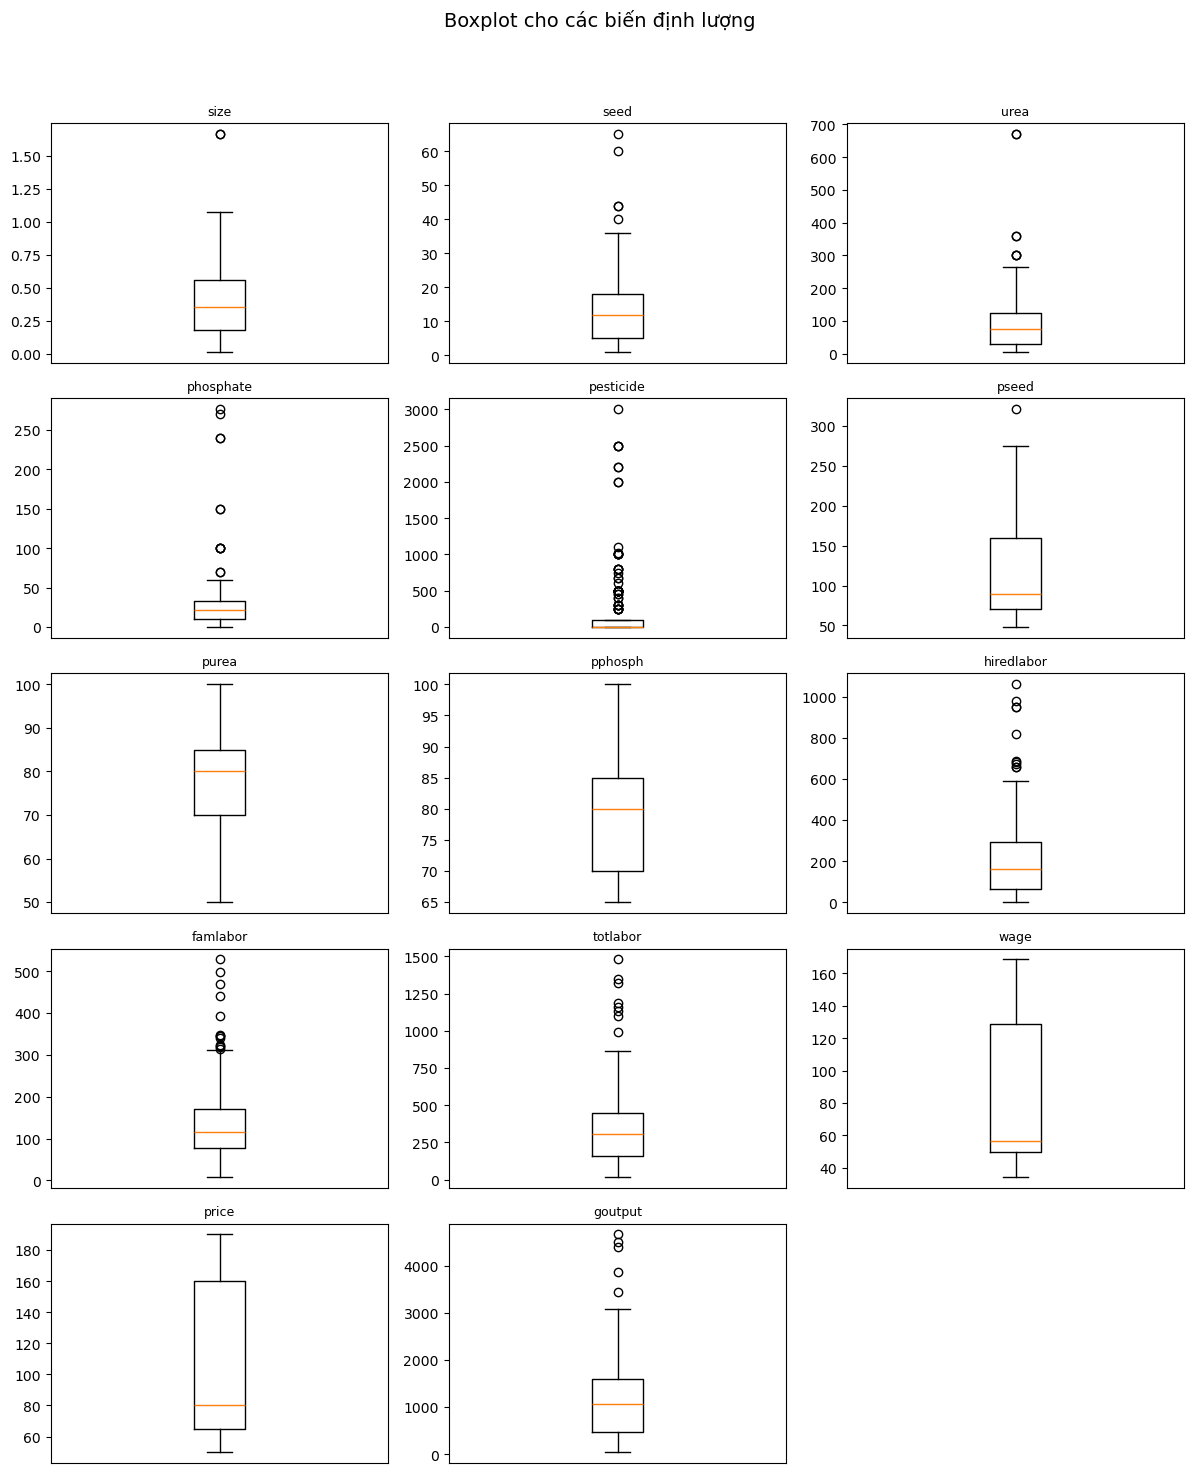

In [144]:
print("Các biến định lượng (quantitative_vars):")
print(quantitative_vars)

n = len(quantitative_vars)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(4*cols, 3*rows))

for i, var in enumerate(quantitative_vars):
    plt.subplot(rows, cols, i+1)
    plt.boxplot(df[var].dropna())
    plt.title(var, fontsize=9)
    plt.xticks([])

plt.suptitle("Boxplot cho các biến định lượng", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Vẽ đồ thị 

BƯỚC 3. TRỰC QUAN HÓA



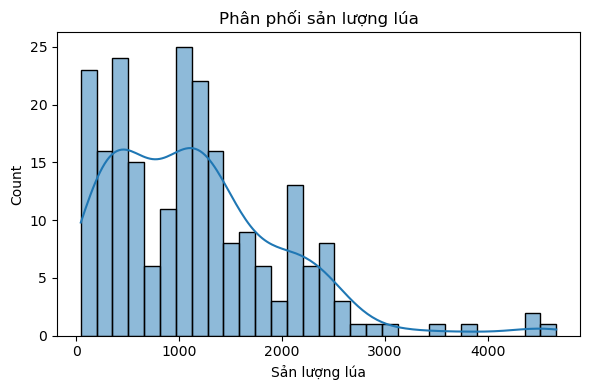

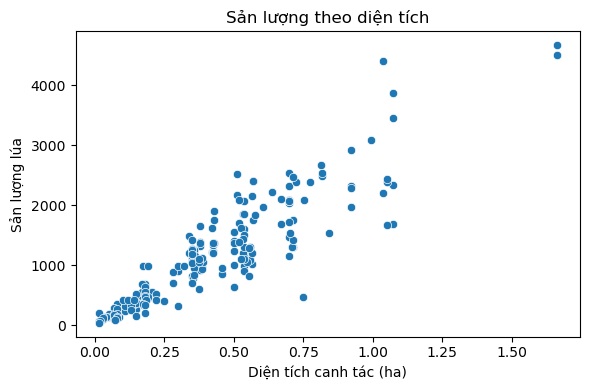

In [145]:
print("="*60)
print("BƯỚC 3. TRỰC QUAN HÓA")
print("="*60, "\n")

# Histogram sản lượng
plt.figure(figsize=(6,4))
sns.histplot(df["goutput"], bins=30, kde=True)
plt.xlabel(VAR_LABELS["goutput"])
plt.title("Phân phối sản lượng lúa")
plt.tight_layout()
#plt.savefig("figures/hist_goutput.png")
plt.show()  
plt.close()

# Scatter: sản lượng ~ diện tích 
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["size"], y=df["goutput"]) # sửa size là được
plt.xlabel(VAR_LABELS["size"])
plt.ylabel(VAR_LABELS["goutput"])
plt.title("Sản lượng theo diện tích")
plt.tight_layout()
#plt.savefig("figures/scatter_goutput_size.png")
plt.show()  
plt.close()



Kiểm đinh OLS

In [146]:
print("="*60)
print("BƯỚC 5. KIỂM TRA ĐIỀU KIỆN TỒN TẠI NGHIỆM OLS")
print("="*60)

# ------------------------------------------------------------
# 5.1. Xây dựng ma trận thiết kế X
# ------------------------------------------------------------
X_vars = (
    [v for v in VAR_LABELS if v != "goutput"]
    + list(BINARY_LABELS.keys())
)
X_full = sm.add_constant(df[X_vars])

# ------------------------------------------------------------
# 5.2. Kiểm tra hạng và định thức X'X
# ------------------------------------------------------------
XtX = X_full.T @ X_full
det_xtx = np.linalg.det(XtX)
rank_X = np.linalg.matrix_rank(X_full)

print(f"Số biến (kể cả hằng số): {X_full.shape[1]}")
print(f"Hạng của ma trận X: {rank_X}")
print(f"det(X'X) = {det_xtx:.6e}")

if rank_X == X_full.shape[1] and det_xtx != 0:
    print("→ Ma trận X có hạng đầy đủ.")
    print("→ det(X'X) ≠ 0 ⇒ Nghiệm OLS tồn tại duy nhất.\n")
else:
    print("CẢNH BÁO:")
    print("→ Ma trận X không có hạng đầy đủ.")
    print("→ Có thể tồn tại đa cộng tuyến hoàn hảo.")
    print("→ Nghiệm OLS không tồn tại hoặc không duy nhất.\n")



BƯỚC 5. KIỂM TRA ĐIỀU KIỆN TỒN TẠI NGHIỆM OLS
Số biến (kể cả hằng số): 14
Hạng của ma trận X: 14
det(X'X) = 3.382950e+61
→ Ma trận X có hạng đầy đủ.
→ det(X'X) ≠ 0 ⇒ Nghiệm OLS tồn tại duy nhất.



Ước lượng mô hình

In [147]:
print("="*60)
print("BƯỚC 6. ƯỚC LƯỢNG MÔ HÌNH ĐẦY ĐỦ")
print("="*60, "\n")

y = df["goutput"]     # Biến phụ thuộc
model_full = sm.OLS(y, X_full).fit() #
print(model_full.summary(), "\n")

print("----- REGRESSION STATISTICS -----")

reg_stats = pd.DataFrame({
    "Statistic": [
        "Multiple R",
        "R Square",
        "Adjusted R Square",
        "Standard Error",
        "Observations"
    ],
    "Value": [
        np.sqrt(model_full.rsquared),
        model_full.rsquared,
        model_full.rsquared_adj,
        np.sqrt(model_full.scale),
        int(model_full.nobs)
    ]
})

# Hiển thị nhiều chữ số để tránh làm tròn quá sớm
print(reg_stats.round(8))
print()



print("----- ANOVA -----")

anova_table = pd.DataFrame({
    "Source": ["Regression", "Residual", "Total"],
    "df": [
        model_full.df_model,
        model_full.df_resid,
        model_full.df_model + model_full.df_resid
    ],
    "Sum of Squares": [
        model_full.ess, # SSR
        model_full.ssr, # SSE
        model_full.centered_tss # SST
    ],
    "F": [
        model_full.fvalue, 
        "",
        ""
    ],
    "Prob > F": [
        model_full.f_pvalue,
        "",
        ""
    ]
})

print(anova_table.round(6))
print()

print("----- COEFFICIENTS TABLE -----")

coef_table = model_full.summary2().tables[1].round(6)
print(coef_table)
print()

print("Ghi chú:")
print("- Các hệ số được kiểm định bằng kiểm định t riêng phần.")
print("- Kiểm định F đánh giá ý nghĩa thống kê tổng thể của mô hình.\n")



BƯỚC 6. ƯỚC LƯỢNG MÔ HÌNH ĐẦY ĐỦ

                            OLS Regression Results                            
Dep. Variable:                goutput   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     98.47
Date:                Tue, 30 Dec 2025   Prob (F-statistic):           3.00e-81
Time:                        11:30:35   Log-Likelihood:                -1592.5
No. Observations:                 222   AIC:                             3213.
Df Residuals:                     208   BIC:                             3261.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -554.5

VIF

In [148]:
current_vars = [v for v in quantitative_vars if v != "goutput"]

print("Biến ban đầu (quantitative_vars):")
print(current_vars)

while True:
    X = sm.add_constant(df[current_vars])
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
    
    vif = vif[vif["Variable"] != "const"]
    
    max_vif = vif["VIF"].max()
    max_var = vif.loc[vif["VIF"].idxmax(), "Variable"]
    
    print("\nBảng VIF:")
    print(vif.round(3))
    
    if max_vif <= 10:
        print("\nTất cả VIF ≤ 10. Dừng.")
        break
    
    print(f"\nLoại biến '{max_var}' (VIF = {max_vif:.2f})")
    current_vars.remove(max_var)

# CẬP NHẬT BIẾN CHO CÁC BƯỚC SAU
X_vars = current_vars
X_full = sm.add_constant(df[X_vars])

print("\nDanh sách biến sau khi xử lý VIF:")
print(X_vars)

Biến ban đầu (quantitative_vars):
['size', 'seed', 'urea', 'phosphate', 'pesticide', 'pseed', 'purea', 'pphosph', 'hiredlabor', 'famlabor', 'totlabor', 'wage', 'price']

Bảng VIF:
      Variable         VIF
1         size       6.460
2         seed       2.439
3         urea       6.412
4    phosphate       4.139
5    pesticide       1.409
6        pseed       4.416
7        purea      16.543
8      pphosph      17.695
9   hiredlabor  498708.325
10    famlabor  112551.984
11    totlabor  815538.263
12        wage      13.522
13       price      14.075

Loại biến 'totlabor' (VIF = 815538.26)

Bảng VIF:
      Variable     VIF
1         size   6.302
2         seed   2.438
3         urea   6.408
4    phosphate   4.102
5    pesticide   1.407
6        pseed   4.409
7        purea  16.540
8      pphosph  17.692
9   hiredlabor   3.581
10    famlabor   1.723
11        wage  13.369
12       price  13.929

Loại biến 'pphosph' (VIF = 17.69)

Bảng VIF:
      Variable     VIF
1         size   6.283


Kiểm định và chọn biến

In [149]:
print("="*60)
print("BƯỚC 7. BACKWARD ELIMINATION")
print("="*60, "\n")

def backward_elimination_with_X(X, y, alpha=0.05):
    """
    Backward elimination trả về cả model và ma trận X mới
    """
    Xc = X.copy()
    removed_vars = []  # 🟢 Lưu biến đã loại
    remaining_vars = list(Xc.columns)  # 🟢 Lưu biến còn lại
    
    print("Quá trình backward elimination:")
    print("-" * 50)
    
    while True:
        model = sm.OLS(y, Xc).fit()
        pvals = model.pvalues.drop("const") if "const" in model.pvalues else model.pvalues
        
        if len(pvals) == 0:  # Chỉ còn constant
            break
            
        if pvals.max() > alpha:
            var = pvals.idxmax()
            removed_vars.append(var)
            
            print(f"Vòng {len(removed_vars)}: Loại '{VAR_LABELS.get(var, var)}'")
            print(f"  p-value = {pvals.max():.4f}")
            print(f"  Biến còn lại: {len(Xc.columns)-1}")
            
            Xc = Xc.drop(columns=[var])
            remaining_vars.remove(var)
        else:
            break
    
    # Fit model cuối
    final_model = sm.OLS(y, Xc).fit()
    
    print("-" * 50)
    print(f"Kết thúc: Loại {len(removed_vars)} biến")
    print(f"Còn lại {len(remaining_vars)} biến")
    
    # 🟢 TRẢ VỀ NHIỀU THỨ
    return {
        'model': final_model,          # Mô hình cuối
        'X_final': Xc,                 # Ma trận X cuối
        'removed_vars': removed_vars,  # Biến đã loại
        'final_vars': remaining_vars,  # Biến còn lại
        'final_formula': ' + '.join(remaining_vars)  # Công thức
    }

# Gọi hàm mới
results = backward_elimination_with_X(X_full, y)

# 🟢 Bây giờ bạn có TẤT CẢ:
#final_model = results['model']          # Model như cũ
model_final = results['model']
X_final = results['X_final']            # 🆕 MA TRẬN X MỚI
removed = results['removed_vars']       # 🆕 Biến đã loại
final_vars = results['final_vars']      # 🆕 Biến còn lại

print("\nKẾT QUẢ CHI TIẾT:")
print(f"1. Số biến đã loại: {len(removed)}")
print(f"2. Biến đã loại: {removed}")
print(f"3. Biến còn lại: {final_vars}")
print(f"4. Số cột trong X_final: {X_final.shape[1]}")

# ===================== BƯỚC 7.5. KIỂM ĐỊNH Ý NGHĨA SAU KHI CHỌN BIẾN ======================
print("="*60)
print("BƯỚC 7.5. KIỂM ĐỊNH Ý NGHĨA MÔ HÌNH CUỐI")
print("="*60, "\n")

print("----- REGRESSION STATISTICS (FINAL MODEL) -----")

reg_stats_final = pd.DataFrame({
    "Statistic": [
        "Multiple R",
        "R Square",
        "Adjusted R Square",
        "Standard Error",
        "Observations"
    ],
    "Value": [
        np.sqrt(model_final.rsquared),
        model_final.rsquared,
        model_final.rsquared_adj,
        np.sqrt(model_final.scale),
        int(model_final.nobs)
    ]
})

print(reg_stats_final.round(8))
print()



print("----- ANOVA (FINAL MODEL) -----")

anova_final = pd.DataFrame({
    "Source": ["Regression", "Residual", "Total"],
    "df": [
        model_final.df_model,
        model_final.df_resid,
        model_final.df_model + model_final.df_resid
    ],
    "Sum of Squares": [
        model_final.ess,          # SSR
        model_final.ssr,          # SSE
        model_final.centered_tss  # SST
    ],
    "F": [
        model_final.fvalue,
        "",
        ""
    ],
    "Prob > F": [
        model_final.f_pvalue,
        "",
        ""
    ]
})

print(anova_final.round(6))
print()


print("----- COEFFICIENTS (FINAL MODEL) -----")
print(model_final.summary2().tables[1].round(6))
print()

print("Ghi chú:")
print("- Các hệ số được kiểm định bằng kiểm định t riêng phần.")
print("- Kiểm định F đánh giá ý nghĩa thống kê tổng thể của mô hình.\n")

compare = pd.DataFrame({
    "Mô hình": ["Ban đầu", "Sau backward"],
    "Số biến": [X_full.shape[1]-1, X_final.shape[1]-1],
    "R²": [model_full.rsquared, model_final.rsquared],
    "Adj R²": [model_full.rsquared_adj, model_final.rsquared_adj]
})

print(compare.round(4))



BƯỚC 7. BACKWARD ELIMINATION

Quá trình backward elimination:
--------------------------------------------------
Vòng 1: Loại 'Giá giống'
  p-value = 0.6301
  Biến còn lại: 10
Vòng 2: Loại 'Lượng phân lân (kg)'
  p-value = 0.6437
  Biến còn lại: 9
Vòng 3: Loại 'Tiền công lao động'
  p-value = 0.5673
  Biến còn lại: 8
Vòng 4: Loại 'Chi phí thuốc BVTV'
  p-value = 0.5171
  Biến còn lại: 7
Vòng 5: Loại 'Lao động thuê (công)'
  p-value = 0.2545
  Biến còn lại: 6
Vòng 6: Loại 'Lượng giống sử dụng (kg)'
  p-value = 0.0676
  Biến còn lại: 5
--------------------------------------------------
Kết thúc: Loại 6 biến
Còn lại 5 biến

KẾT QUẢ CHI TIẾT:
1. Số biến đã loại: 6
2. Biến đã loại: ['pseed', 'phosphate', 'wage', 'pesticide', 'hiredlabor', 'seed']
3. Biến còn lại: ['const', 'size', 'urea', 'purea', 'famlabor']
4. Số cột trong X_final: 5
BƯỚC 7.5. KIỂM ĐỊNH Ý NGHĨA MÔ HÌNH CUỐI

----- REGRESSION STATISTICS (FINAL MODEL) -----
           Statistic       Value
0         Multiple R    0.922921
1

Kiểm định ý nghĩa của hồi quy

In [150]:
print("----- KIỂM ĐỊNH F (Ý NGHĨA HỒI QUY TỔNG THỂ) -----")

print("\nGiả thuyết kiểm định:")
print("H₀: Tất cả các hệ số hồi quy riêng (trừ hằng số) đều bằng 0")
print("H₁: Tồn tại ít nhất một hệ số khác 0\n")

# Lấy các đại lượng từ model_final
SSR = model_final.ess                 # Sum of Squares Regression
SSE = model_final.ssr                 # Sum of Squares Error
SST = model_final.centered_tss        # Total Sum of Squares

R2  = model_final.rsquared
R2_adj = model_final.rsquared_adj

k = int(model_final.df_model)         # số biến độc lập (không tính const)
df_resid = int(model_final.df_resid)  # n - k - 1
n = int(model_final.nobs)             # số quan sát

F_stat = model_final.fvalue
p_value_F = model_final.f_pvalue
alpha = 0.05

# In kết quả
print(f"Số quan sát (n)                 = {n}")
print(f"Số biến độc lập (k)             = {k}")
print(f"Bậc tự do phần dư (n - k - 1)   = {df_resid}\n")

print(f"SSR (Sum of Squares Regression) = {SSR:.6f}")
print(f"SSE (Sum of Squares Error)      = {SSE:.6f}")
print(f"SST (Total Sum of Squares)      = {SST:.6f}\n")

print(f"R-squared                       = {R2:.6f}")
print(f"Adjusted R-squared              = {R2_adj:.6f}\n")

print(f"F-statistic = {F_stat:.4f}")
print(f"p-value     = {p_value_F:.6f}")

if p_value_F < alpha:
    print("→ Bác bỏ H₀: Mô hình hồi quy có ý nghĩa thống kê tổng thể.")
else:
    print("→ Không bác bỏ H₀: Mô hình không có ý nghĩa thống kê.")



----- KIỂM ĐỊNH F (Ý NGHĨA HỒI QUY TỔNG THỂ) -----

Giả thuyết kiểm định:
H₀: Tất cả các hệ số hồi quy riêng (trừ hằng số) đều bằng 0
H₁: Tồn tại ít nhất một hệ số khác 0

Số quan sát (n)                 = 222
Số biến độc lập (k)             = 4
Bậc tự do phần dư (n - k - 1)   = 217

SSR (Sum of Squares Regression) = 134693162.862580
SSE (Sum of Squares Error)      = 23437497.772555
SST (Total Sum of Squares)      = 158130660.635135

R-squared                       = 0.851784
Adjusted R-squared              = 0.849052

F-statistic = 311.7698
p-value     = 0.000000
→ Bác bỏ H₀: Mô hình hồi quy có ý nghĩa thống kê tổng thể.


Vẽ biểu đồ sau khi loại bỏ biến

Q–Q PLOT PHẦN DƯ (KIỂM ĐỊNH PHÂN PHỐI CHUẨN)

<Figure size 600x400 with 0 Axes>

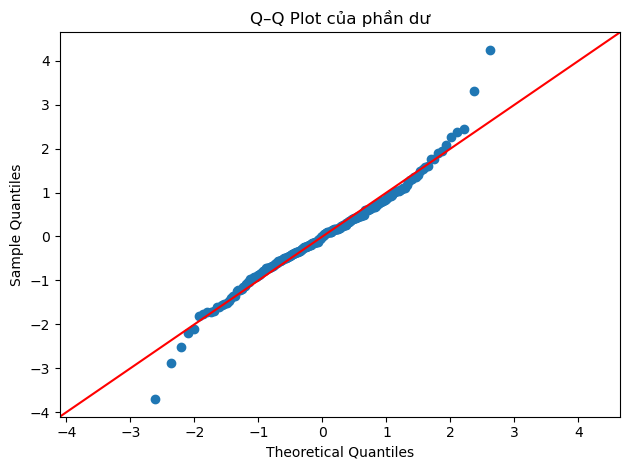

In [151]:
resid = model_final.resid
fitted = model_final.fittedvalues

# Q-Q plot phần dư
plt.figure(figsize=(6, 4))
sm.qqplot(resid, line="45", fit=True)
plt.title("Q–Q Plot của phần dư")
plt.tight_layout()
#plt.savefig("figures/qqplot_residuals.png")
plt.show() 
plt.close()


BOXPLOT PHẦN DƯ (PHÁT HIỆN OUTLIER)

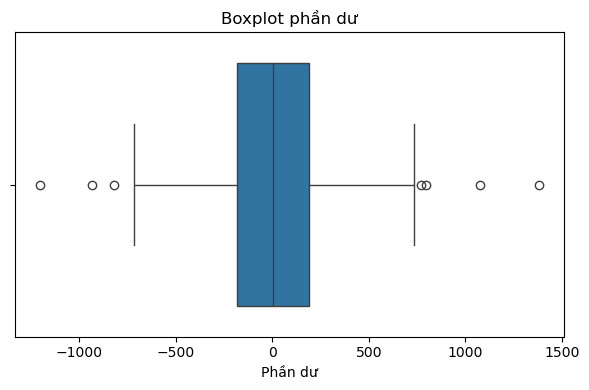

In [152]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=resid)
plt.xlabel("Phần dư")
plt.title("Boxplot phần dư")
plt.tight_layout()
#plt.savefig("figures/boxplot_residuals.png")
plt.show()
plt.close()


SCATTER PLOT: PHẦN DƯ – GIÁ TRỊ DỰ ĐOÁN

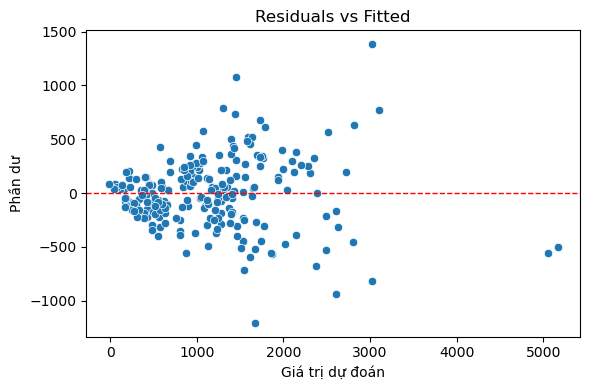

In [153]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Giá trị dự đoán")
plt.ylabel("Phần dư")
plt.title("Residuals vs Fitted")
plt.tight_layout()
#plt.savefig("figures/residuals_vs_fitted.png")
plt.show()
plt.close()


HISTOGRAM PHẦN DƯ (PHÂN PHỐI)

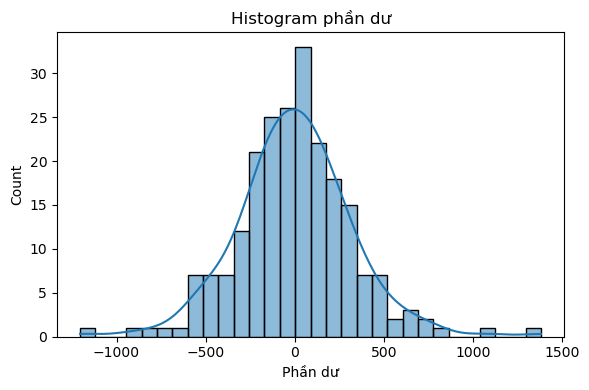

In [154]:
plt.figure(figsize=(6, 4))
sns.histplot(resid, bins=30, kde=True)
plt.xlabel("Phần dư")
plt.title("Histogram phần dư")
plt.tight_layout()
#plt.savefig("figures/hist_residuals.png")
plt.show()
plt.close()


Kiểm định phân phối phần dư

In [155]:
def chi2_normality_table(data, var_name="X", k=10, alpha=0.05):
    """
    Kiểm định Chi-square cho giả định phân phối chuẩn
    (có bảng n_i và nP_i).
    """

    n = len(data)

    # Ước lượng tham số phân phối chuẩn
    mu_hat = np.mean(data)
    sigma_hat = np.std(data, ddof=1)

    # Chia k lớp theo percentiles
    bins = np.percentile(data, np.linspace(0, 100, k + 1))

    # n_i: tần số quan sát
    n_i, _ = np.histogram(data, bins=bins)

    # nP_i: tần số kỳ vọng
    nP_i = []
    for i in range(k):
        a = bins[i]
        b = bins[i + 1]
        Pi = norm.cdf(b, mu_hat, sigma_hat) - norm.cdf(a, mu_hat, sigma_hat)
        nP_i.append(n * Pi)

    nP_i = np.array(nP_i)

    # Thành phần thống kê Chi-square
    diff = n_i - nP_i
    chi_components = (diff ** 2) / nP_i

    # Bậc tự do
    df = k - 3
    chi2_stat = np.sum(chi_components)
    critical_value = chi2.ppf(1 - alpha, df)

    # Chuỗi mô tả khoảng
    intervals = [f"({bins[i]:.4f}, {bins[i+1]:.4f}]" for i in range(k)]

    # Bảng kết quả
    test_table = pd.DataFrame({
        "Khoảng": intervals,
        "a_{i-1}": bins[:-1],
        "a_i": bins[1:],
        "n_i (tần số quan sát)": n_i,
        "nP_i (tần số kỳ vọng)": nP_i,
        "n_i - nP_i": diff,
        "(n_i - nP_i)^2": diff**2,
        "(n_i - nP_i)^2 / nP_i": chi_components
    })

    for col in [
        "nP_i (tần số kỳ vọng)",
        "n_i - nP_i",
        "(n_i - nP_i)^2",
        "(n_i - nP_i)^2 / nP_i"
    ]:
        test_table[col] = test_table[col].round(4)

    # In kết quả
    print("\n" + "=" * 80)
    print(f"KIỂM ĐỊNH CHI-SQUARE CHO TÍNH CHUẨN ({var_name})")
    print("=" * 80)
    print(f"n = {n}, k = {k}, df = {df}")
    print(f"μ̂ = {mu_hat:.4f}, σ̂ = {sigma_hat:.4f}")
    print("\nBẢNG TÍNH CHI TIẾT:")
    display(test_table)

    print("\nKẾT QUẢ KIỂM ĐỊNH:")
    print(f"Chi-square statistic = {chi2_stat:.4f}")
    print(f"Giá trị tới hạn = {critical_value:.4f}")

    if chi2_stat > critical_value:
        print("KẾT LUẬN: Bác bỏ H₀ → Phần dư KHÔNG tuân theo phân phối chuẩn.")
    else:
        print("KẾT LUẬN: Không bác bỏ H₀ → Phần dư CÓ THỂ xem là phân phối chuẩn.")

    return {
        "table": test_table,
        "chi2_stat": chi2_stat,
        "critical": critical_value,
        "df": df
    }


# =========================================================
# CHẠY KIỂM ĐỊNH CHO PHẦN DƯ MÔ HÌNH HỒI QUY CUỐI
# (YÊU CẦU: model_final đã tồn tại)
# =========================================================

residuals = model_final.resid.values

chi2_residuals_results = chi2_normality_table(
    data=residuals,
    var_name="Residuals of Final Regression Model",
    k=10,
    alpha=0.05
)


KIỂM ĐỊNH CHI-SQUARE CHO TÍNH CHUẨN (Residuals of Final Regression Model)
n = 222, k = 10, df = 7
μ̂ = 0.0000, σ̂ = 325.6563

BẢNG TÍNH CHI TIẾT:


,Khoảng,a_{i-1},a_i,n_i (tần số quan sát),nP_i (tần số kỳ vọng),n_i - nP_i,(n_i - nP_i)^2,(n_i - nP_i)^2 / nP_i
0,"(-1204.4907, -388.2544]",-1204.490706,-388.254366,23,25.8583,-2.8583,8.1699,0.3160
1,"(-388.2544, -231.6890]",-388.254366,-231.688978,22,27.0429,-5.0429,25.4305,0.9404
2,"(-231.6890, -142.0853]",-231.688978,-142.085272,22,20.6251,1.3749,1.8903,0.0916
3,"(-142.0853, -74.1300]",-142.085272,-74.130014,22,17.4621,4.5379,20.5928,1.1793
4,"(-74.1300, 4.0885]",-74.130014,4.088511,22,21.0994,0.9006,0.8110,0.0384
5,"(4.0885, 59.1702]",4.088511,59.170212,22,14.8919,7.1081,50.5252,3.3928
6,"(59.1702, 139.0691]",59.170212,139.069077,22,20.6986,1.3014,1.6938,0.0818
7,"(139.0691, 222.7360]",139.069077,222.736045,22,19.4637,2.5363,6.4330,0.3305
8,"(222.7360, 355.5308]",222.736045,355.530829,22,24.3147,-2.3147,5.3577,0.2203
9,"(355.5308, 1381.5853]",355.530829,1381.585262,23,30.5169,-7.5169,56.5035,1.8516



KẾT QUẢ KIỂM ĐỊNH:
Chi-square statistic = 8.4427
Giá trị tới hạn = 14.0671
KẾT LUẬN: Không bác bỏ H₀ → Phần dư CÓ THỂ xem là phân phối chuẩn.


Kiểm định phương sai phần dư thay đổi

In [156]:
# ===================== BƯỚC 9. KIỂM ĐỊNH PHƯƠNG SAI THAY ĐỔI ======================
print("="*60)
print("BƯỚC 9. KIỂM ĐỊNH PHƯƠNG SAI THAY ĐỔI (BREUSCH–PAGAN)")
print("="*60, "\n")

from statsmodels.stats.diagnostic import het_breuschpagan

# Phần dư của mô hình cuối
residuals = model_final.resid

# Ma trận X (KHÔNG bao gồm biến phụ thuộc)
X_bp = X_final.copy()

# Thực hiện kiểm định Breusch–Pagan
bp_test = het_breuschpagan(residuals, X_bp)

bp_results = pd.DataFrame({
    "Statistic": [
        "LM Statistic",
        "LM p-value",
        "F Statistic",
        "F p-value"
    ],
    "Value": bp_test
})

print("KẾT QUẢ KIỂM ĐỊNH BREUSCH–PAGAN:")
print(bp_results.round(6))
print()

# Kết luận ở mức ý nghĩa 5%
alpha = 0.05
p_value = bp_test[1]  # LM p-value

if p_value < alpha:
    print("KẾT LUẬN: Bác bỏ H₀ → Có hiện tượng phương sai thay đổi.")
else:
    print("KẾT LUẬN: Không bác bỏ H₀ → Không phát hiện phương sai thay đổi.")

BƯỚC 9. KIỂM ĐỊNH PHƯƠNG SAI THAY ĐỔI (BREUSCH–PAGAN)

KẾT QUẢ KIỂM ĐỊNH BREUSCH–PAGAN:
      Statistic      Value
0  LM Statistic  50.654095
1    LM p-value   0.000000
2   F Statistic  16.037644
3     F p-value   0.000000

KẾT LUẬN: Bác bỏ H₀ → Có hiện tượng phương sai thay đổi.


KIỂM ĐỊNH t – Ý NGHĨA HỆ SỐ HỒI QUY RIÊNG

In [157]:
print("----- KIỂM ĐỊNH t (Ý NGHĨA HỆ SỐ HỒI QUY RIÊNG) -----")

print("Giả thuyết kiểm định t:")
print("H₀: βᵢ = 0  (biến không ảnh hưởng đến sản lượng)")
print("H₁: βᵢ ≠ 0  (biến có ảnh hưởng đến sản lượng)\n")

# Lấy bảng hệ số từ mô hình CUỐI
coef_table_final = model_final.summary2().tables[1].round(6)
print(coef_table_final, "\n")

print("KẾT LUẬN KIỂM ĐỊNH t CHO TỪNG BIẾN:")

for var in coef_table_final.index:
    if var == "const":
        continue

    coef = coef_table_final.loc[var, "Coef."]
    pval = coef_table_final.loc[var, "P>|t|"]
    ci_low = coef_table_final.loc[var, "[0.025"]
    ci_high = coef_table_final.loc[var, "0.975]"]

    label = VAR_LABELS.get(var, var)

    print(f"- {label}:")
    print(f"  Hệ số chặn = {coef:.6f}")
    print(f"  p-value         = {pval:.6f}")
    print(f"  CI 95%          = [{ci_low:.6f}, {ci_high:.6f}]")

    if pval < alpha:
        print("  → Bác bỏ H₀: Hệ số có ý nghĩa thống kê.\n")
    else:
        print("  → Không bác bỏ H₀: Hệ số không có ý nghĩa thống kê.\n")




----- KIỂM ĐỊNH t (Ý NGHĨA HỆ SỐ HỒI QUY RIÊNG) -----
Giả thuyết kiểm định t:
H₀: βᵢ = 0  (biến không ảnh hưởng đến sản lượng)
H₁: βᵢ ≠ 0  (biến có ảnh hưởng đến sản lượng)

                Coef.    Std.Err.          t     P>|t|       [0.025  \
const     -758.315594  235.677855  -3.217594  0.001490 -1222.826348   
size      1999.535340  140.749981  14.206292  0.000000  1722.123278   
urea         2.101225    0.452758   4.640942  0.000006     1.208858   
purea       10.411288    3.053660   3.409446  0.000776     4.392657   
famlabor     0.638112    0.272109   2.345062  0.019927     0.101797   

               0.975]  
const     -293.804841  
size      2276.947401  
urea         2.993592  
purea       16.429919  
famlabor     1.174427   

KẾT LUẬN KIỂM ĐỊNH t CHO TỪNG BIẾN:
- Diện tích canh tác (ha):
  Hệ số chặn = 1999.535340
  p-value         = 0.000000
  CI 95%          = [1722.123278, 2276.947401]
  → Bác bỏ H₀: Hệ số có ý nghĩa thống kê.

- Lượng phân urê (kg):
  Hệ số chặn = 2.1012